In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from experiment_train import *
from experiment_datasets import *
from helpers import *
from tqdm import tqdm
import matplotlib

Using TensorFlow backend.


Initialized TensorFlow


Problem: Taylor is WAY OFF for $np>1$...

Hypothesis: need to add second term to the mean as only MEAN is off and variance is fine.
Need to calculate $L''_{ii}$, diagonal of the Hessian

A bit better (for second layer) with it....

In [26]:
# network configuration
N = [100, 100]

def get_p_arr(p):
    """ p array with failure on the first layer """
    return [0, p]  + [0] * (len(N))

# prob. of failure at inference
p_inf = 1e-5
p_inference = get_p_arr(p_inf)

# prob. of failure at train
p_trains = np.linspace(0, 1.2 * p_inf, 10)

# Lips. coeff
KLips = 1.

# activation function
activation = 'sigmoid'

# number of repeats for error estimation
# see below for explanation
repetitions = 6

# number of runs for each p
runs = 10

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010      
Total params: 89,610
Trainable params: 89,610
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 1s 20us/step - loss: 0.2449 - categorical_accuracy: 0.8003 - mean_squared_error: 0.0473 - mean_absolute_error: 0.1386 - val_loss: 0.1097 - val_categorical_accuracy: 0.8862 - val_mean_squared_error: 0.0305 - val_mean_absolute_error: 0.1188
Epoch 2/10
60000/60000 [==============================]

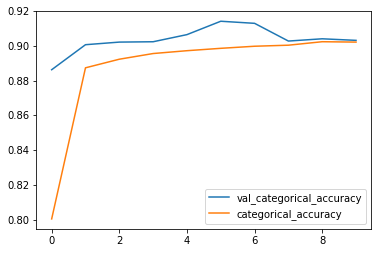

Creating network for 784-dimensional input and 10-dimensional output, with 2 hidden layers
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 100)               78500     
_________________________________________________________________
Crashes (Lambda)             (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1010      
Total params: 89,610
Trainable params: 89,610
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 100)       

In [27]:
exp = MNISTExperiment(N = N, p_inference = p_inference, p_train = get_p_arr(0), KLips = KLips, epochs = 10,
                                      activation = activation, reg_type = 'l2', reg_coeff = 1e-3, do_print = True,
                                      name = 'experiment_weights', seed = None, batch_size = 100)

In [478]:
truth = exp.y_train

In [479]:
def crashing_loss():
    prediction = exp.predict_crashing(exp.x_train, repetitions = 1)
    prediction = prediction.reshape(60000, 10)
    loss = np.mean(np.square(prediction - truth))
    return loss

In [470]:
def correct_loss():
    prediction = exp.predict_correct(exp.x_train)
    #prediction = prediction.reshape(60000, 10)
    loss = np.mean(np.square(prediction - truth))
    return loss

In [396]:
correct = correct_loss()

In [397]:
crashing = [crashing_loss() for _ in tqdm(range(20))]

100%|██████████| 20/20 [00:19<00:00,  1.04it/s]


In [398]:
correct * 100

0.640429319700057

(array([3., 1., 2., 2., 2., 4., 2., 1., 1., 2.]),
 array([0.64042332, 0.64043843, 0.64045354, 0.64046865, 0.64048376,
        0.64049887, 0.64051398, 0.6405291 , 0.64054421, 0.64055932,
        0.64057443]),
 <a list of 10 Patch objects>)

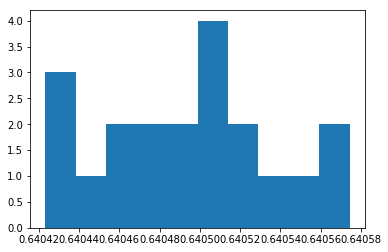

In [480]:
plt.hist(np.array(crashing) * 100)

In [481]:
# computing probability delta of bad crash >= alpha

In [482]:
def q_factor(array):
    """ q-balanced factor """
    array = np.abs(array)
    assert np.max(array) > 0, "Cannot compute q-factor for zero array"
        
    return np.min(array) / np.max(array)

# balancedness
q = q_factor(np.linalg.norm(exp.W[1], axis = 1, ord = 1) ** 2)

# weight norm
Wnorm = np.linalg.norm(exp.W[1].flatten(), ord = 1)

# number of neurons
n = N[1]

# W matrix
W = exp.model_correct.layers[1].weights[0]

# loss function
loss = exp.loss

# probability of failure
p = p_inf

# get TF session
sess = get_session()

# q-factor
print(q, Wnorm)

# pseudo-weights
W1 = exp.model_correct.layers[1].output

2.1850873e-10 119.189575


In [483]:
def get_feed():
    """ Return feed dictionary for train dataset """
    return {exp.model_correct.input: exp.x_train, exp.output_tensor: exp.y_train}

In [510]:
# M1 ~ loss gradient
M_1 = np.linalg.norm(sess.run(tf.multiply(W1, tf.gradients(exp.loss, W1)[0]), get_feed()), ord = 1) / len(exp.x_train)
print(M_1)
M_0 = 1.

0.006751917012532552


In [512]:
Wnorm

119.189575

In [511]:
# Maximal Hessian eigenvalue (handwavy)
M_2 = 1

# maximal alpha
alpha_max = 1. / 2 * M_0 / M_2 / Wnorm ** 2

# maximal alpha
print(alpha_max)

3.5196012277701343e-05


In [491]:
# maximal alpha
alpha = alpha_max
#alpha = max(p, alpha)
if alpha > alpha_max:
    alpha = alpha_max
#alpha = min(alpha, alpha_max)
if alpha < p:
    alpha = p
print(alpha)

2.8324276688915037e-05


In [492]:
# target probability to certify
delta_0 = 1. / 8

In [493]:
# certifying low weight perturbation alpha
print(alpha, p)
assert alpha > p, "Alpha must be greater than p"

2.8324276688915037e-05 1e-05


In [494]:
# https://en.wikipedia.org/wiki/Binomial_distribution
def kl_num(x, y):
    """ KL divergence between numbers """
    return x * np.log(x / y) + (1 - x) * np.log((1 - x) / (1 - y))

In [501]:
kl_num(alpha, p)

1.116526371588494e-05

In [498]:
q = 1
delta = np.exp(-n * q * kl_num(alpha, p))

In [509]:
print('Certified', delta)

Certified 0.9988840967120627


In [497]:
assert delta < 1. / 4, "Delta must be small enough"

AssertionError: Delta must be small enough

In [433]:
# calculating mean and variance using Taylor...
err_mean_std = exp._get_bound_b3_loss(exp.x_train, exp.y_train, weights = exp.model_correct.layers[1].output)

In [434]:
# mean squared deviation
mean_mean = np.mean(err_mean_std['mean'] ** 2)

# mean variance
mean_std = np.mean(err_mean_std['std'] ** 2)

In [435]:
Wnorm

1096.1976

In [436]:
var_total = mean_mean + mean_std

In [437]:
print(var_total)

4.114497952672306e-08


In [438]:
print(np.mean(err_mean_std['mean']), np.mean(err_mean_std['std'] ** 2) ** 0.5)
print(np.mean(np.array(crashing)), np.std(crashing))

-5.280081732462471e-08 0.00020284074530279778
0.006404941863158373 4.257723123923872e-07


In [449]:
# 2 * variance =
delta_L = (var_total) ** 0.5 * 4

In [450]:
# total bad loss probability
delta_total = var_total / delta_L ** 2 + delta

In [454]:
print(delta_total)
assert delta_total < 1. / 3, "Must have pfail < 1/3"

0.28527163572124203


In [455]:
# calculating number of repetitions...

In [456]:
Nout = exp.N[-1]

In [457]:
# maximal probability of failure (<1/4)
p_fail = 1. / 3

In [458]:
# target probability
delta_target = 1e-5

In [459]:
m = np.log(Nout / delta_target) / np.log(1 / p_fail)
print('Number of repetitions', np.ceil(m), 'will achieve', delta_target)

Number of repetitions 13.0 will achieve 1e-05


In [461]:
alpha ** 2 * Wnorm ** 2

76.67171730593843

In [518]:
sess.run(tf.gradients(exp.loss, exp.model_correct.input), feed_dict = {exp.x_train[0]})

NameError: name 'feed' is not defined

In [9]:
sess = get_session()

In [10]:
N = 1000000

In [11]:
x = tf.Variable(tf.random.uniform((N,)), tf.float64)

In [12]:
loss = tf.reduce_sum(tf.exp(x))

In [13]:
def grad_and_mult(fcn, x):
    return tf.reduce_sum(tf.multiply(tf.gradients(fcn, x)[0], tf.stop_gradient(x)))

In [22]:
loss = grad_and_mult(loss, x)

In [23]:
sess.run(tf.global_variables_initializer())
#sess.run([x, w])

In [24]:
sess.run(loss)

464207.6

In [34]:
Wl = exp.model_correct.layers[-1].weights[0]

In [37]:
### Trying for a single object...
idx = 10
x = exp.x_train[idx:idx+1]
y = exp.y_train[idx:idx+1]

In [38]:
feed = {exp.model_correct.input: x, exp.output_tensor: y}

In [55]:
h = sess.run(tf.hessians(exp.loss, Wl), feed)[0]

In [56]:
h = np.abs(h)

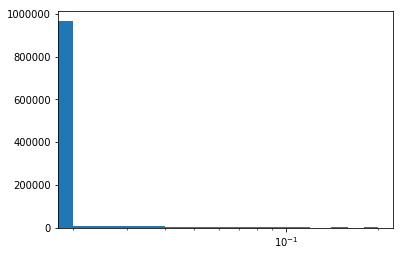

In [57]:
plt.hist(np.abs(h.flatten()))
plt.xscale('log')

In [60]:
np.mean(np.abs(h))

0.0031329184